In [1]:
# importation de quelques librairies

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
# chemin de nos données d'entrainement et de test

train_path = os.getenv('WINE_TRAIN_PATH')
test_path = os.getenv('WINE_TEST_PATH')

# chargement des données

df_train = pd.read_csv(train_path).drop('wine_ID', axis=1)
df_test = pd.read_csv(test_path)

## Analyse des données

In [3]:
# visualisation des données

df_train.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.2              0.16         0.26             7.1      0.054   
1            7.3              0.22         0.31             2.3      0.018   
2            8.9              0.13         0.49             1.0      0.028   
3            6.0              0.17         0.29             9.7      0.044   
4            7.5              0.19         0.34             2.6      0.037   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 41.0                 224.0  0.99660  3.38       0.55   
1                 45.0                  80.0  0.98936  3.06       0.34   
2                  6.0                  24.0  0.99260  2.91       0.32   
3                 33.0                  98.0  0.99536  3.12       0.36   
4                 33.0                 125.0  0.99230  3.10       0.49   

   alcohol  wine_type  target  
0     10.1          0       5  
1     12.9          0       7  
2      9.9          0       5  
3      9.2          0       6  
4     11.1          0       7

In [4]:
# informations sur les données

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4547 entries, 0 to 4546
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4547 non-null   float64
 1   volatile acidity      4547 non-null   float64
 2   citric acid           4547 non-null   float64
 3   residual sugar        4547 non-null   float64
 4   chlorides             4547 non-null   float64
 5   free sulfur dioxide   4547 non-null   float64
 6   total sulfur dioxide  4547 non-null   float64
 7   density               4547 non-null   float64
 8   pH                    4547 non-null   float64
 9   sulphates             4547 non-null   float64
 10  alcohol               4547 non-null   float64
 11  wine_type             4547 non-null   int64  
 12  target                4547 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 461.9 KB


In [5]:
# description des données

df_train.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4547.000000       4547.000000  4547.000000     4547.000000   
mean        7.235364          0.340110     0.318155        5.367572   
std         1.319966          0.166643     0.142942        4.748314   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        2.900000   
75%         7.700000          0.400000     0.390000        8.000000   
max        15.600000          1.580000     1.000000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4547.000000          4547.000000           4547.000000  4547.000000   
mean      0.056112            30.364416            115.502309     0.994700   
std       0.035236            17.868751             56.989343     0.003015   
min       0.012000             1.000000              6.000000     0.987130   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994800   
75%       0.065000            41.000000            156.000000     0.997000   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol    wine_type       target  
count  4547.000000  4547.000000  4547.000000  4547.000000  4547.000000  
mean      3.219477     0.533006    10.496162     0.249835     5.824060  
std       0.163511     0.150728     1.179564     0.432965     0.876346  
min       2.740000     0.220000     8.000000     0.000000     3.000000  
25%       3.110000     0.430000     9.500000     0.000000     5.000000  
50%       3.210000     0.510000    10.300000     0.000000     6.000000  
75%       3.320000     0.600000    11.300000     0.000000     6.000000  
max       4.010000     2.000000    14.200000     1.000000     9.000000

In [6]:
# forme des données

print(df_train.shape, df_test.shape)

(4547, 13) (1950, 13)


<module 'matplotlib.pyplot' from '/Users/samy/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

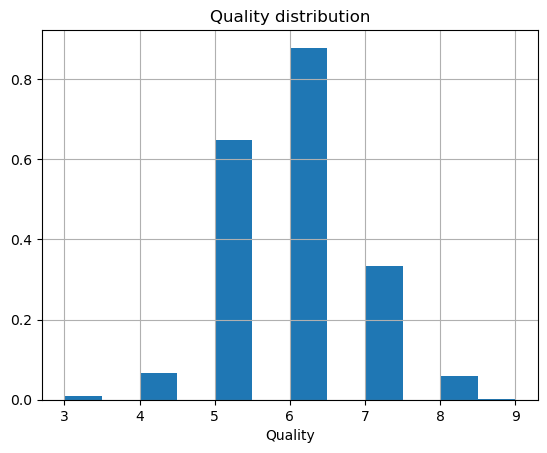

In [7]:
# Disrtibution des classes

df_train['target'].hist(bins=12, density=True)
plt.title('Quality distribution')
plt.xlabel('Quality')
plt

Text(0.5, 1.0, 'Correlation Matrix')

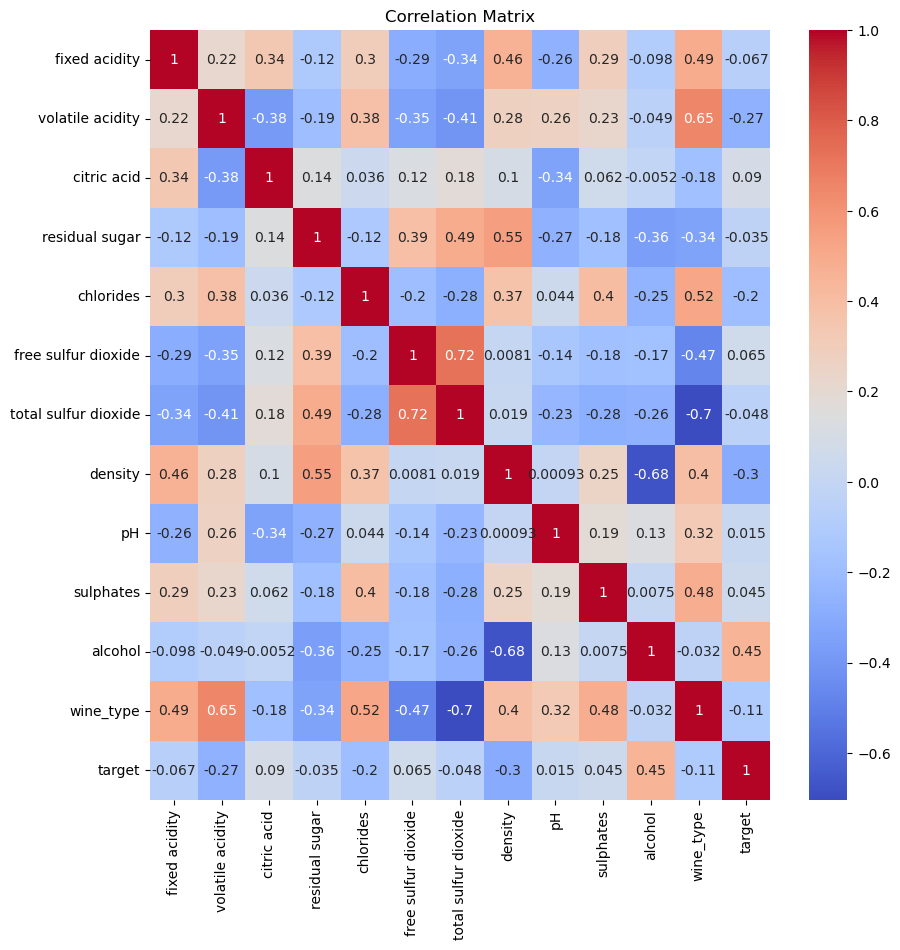

In [8]:
# Matrice de corrélation

plt.figure(figsize=(10, 10))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

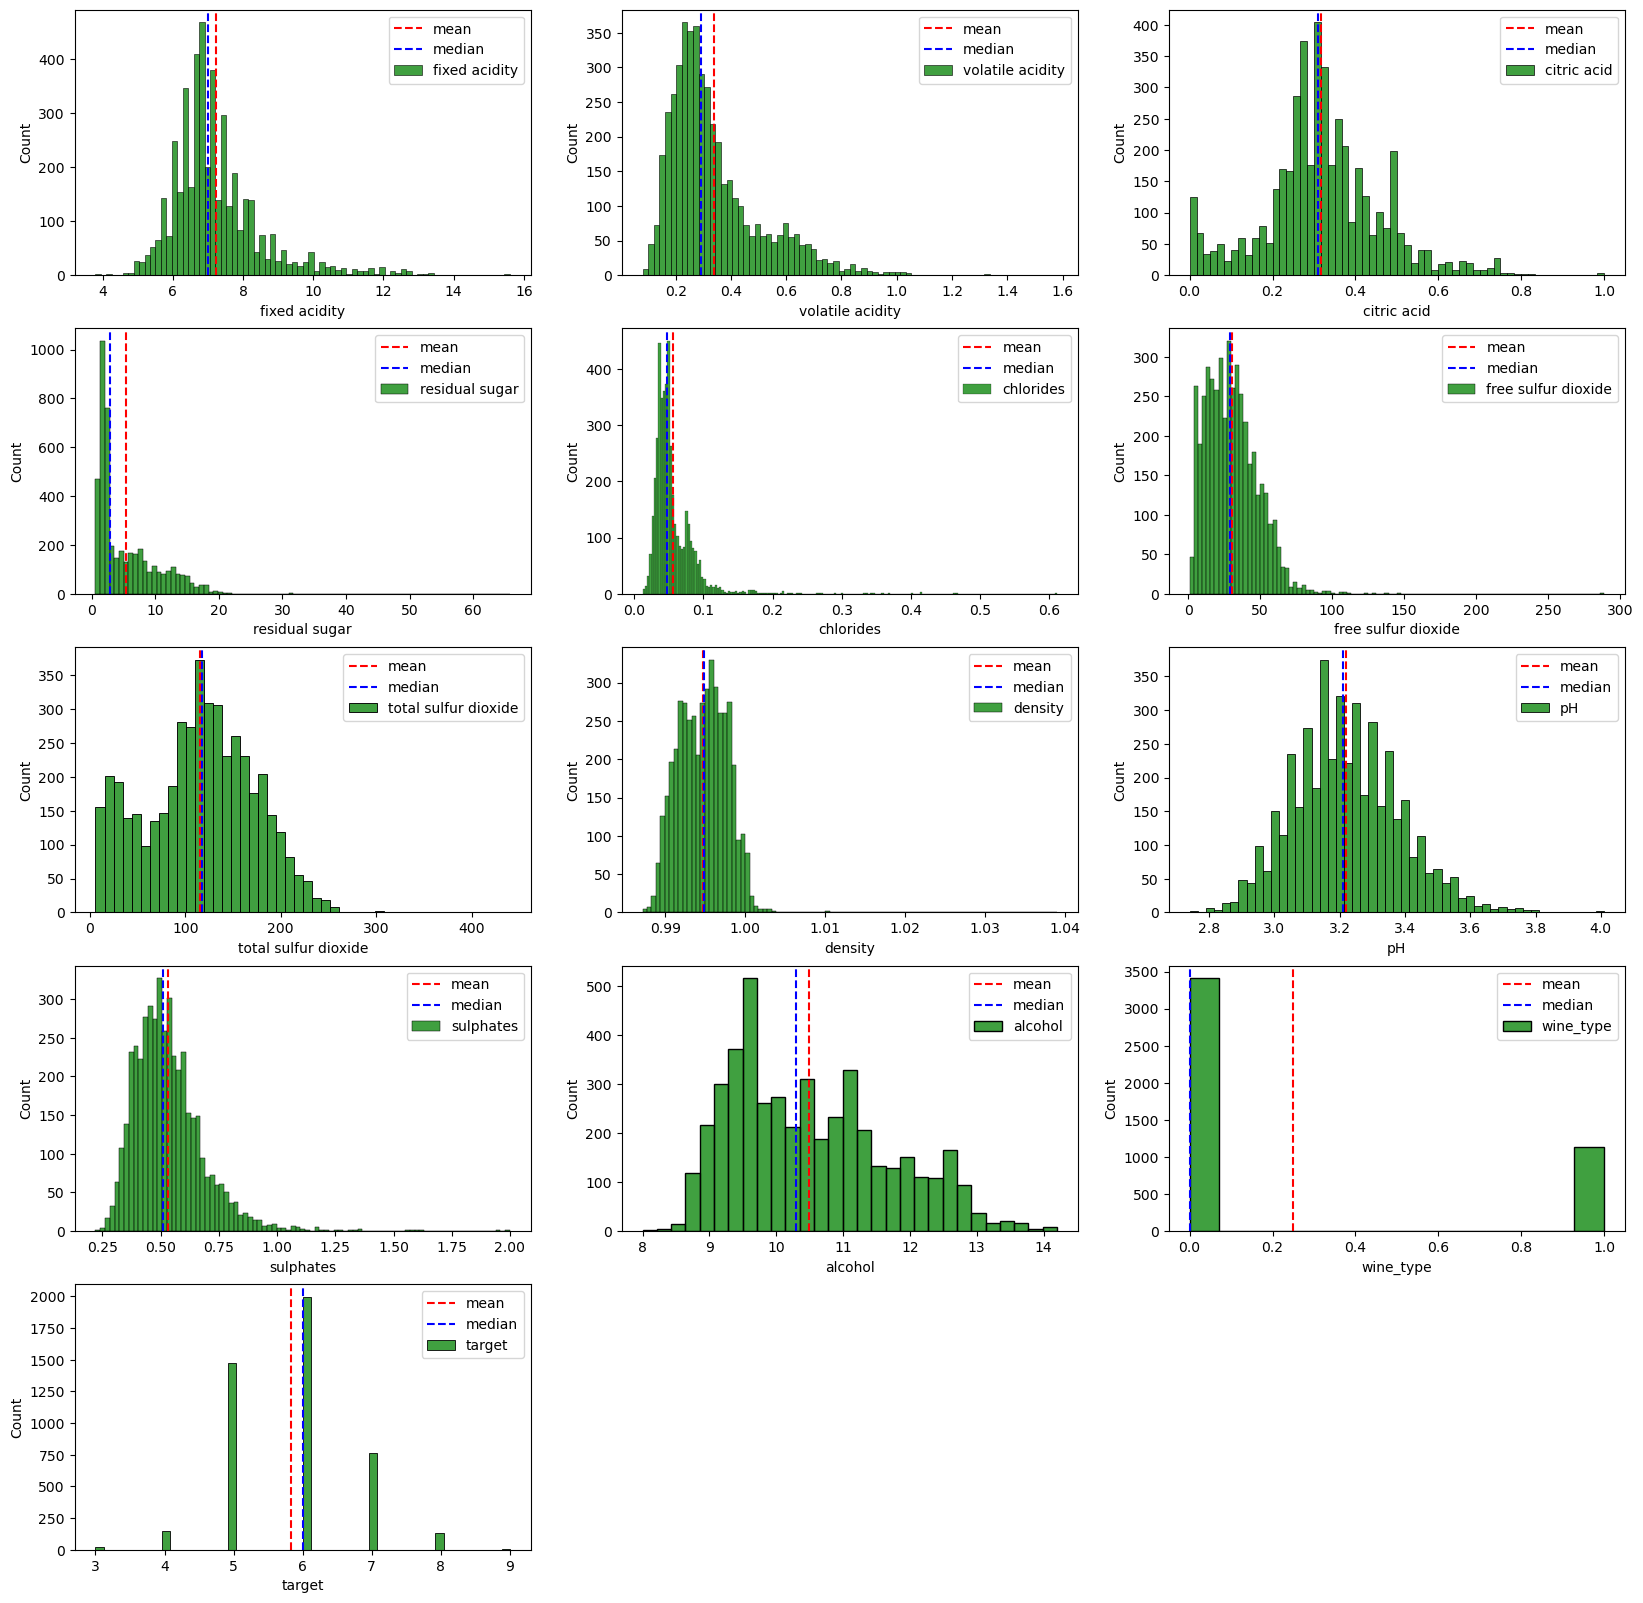

In [9]:
# Distribution des variables

fig = plt.figure(figsize=(20, 20))
for i in range(len(df_train.columns)):
    fig.add_subplot(5, 3, i+1)
    sns.histplot(df_train.iloc[:, i], color='green', label=df_train.columns[i])
    # show the mean and median
    plt.axvline(df_train.iloc[:, i].mean(), linestyle='dashed', color='red', label='mean')
    plt.axvline(df_train.iloc[:, i].median(), linestyle='dashed', color='blue', label='median')
    plt.legend()

## Séparation train-test

In [10]:
# Séparation des données en train test

X = df_train.drop('target', axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Entrainement du modèle

model.fit(X_train, y_train)

# Prédiction sur les données de test

y_preds = model.predict(X_test)

# Evaluation du modèle

print(f"Le r2 vaut : {r2_score(y_test, y_preds)}")

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/linear_regression.csv', index=False)

# soumission des résultats

model = LinearRegression()

model.fit(X, y)

y_preds = model.predict(df_test.drop('wine_ID', axis=1))

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/linear_regression.csv', index=False)



Le r2 vaut : 0.311967248929242


## CatBoost Regressor

In [12]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=10000, depth=10, learning_rate=0.1, loss_function='RMSE', eval_metric='R2', random_seed=42)

# Entrainement du modèle

model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)

# Prédiction sur les données de test

y_preds = model.predict(X_test)

# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/catboost.csv', index=False)

# soumission des résultats

model = CatBoostRegressor(iterations=10000, depth=10, learning_rate=0.1, loss_function='RMSE', eval_metric='R2', random_seed=42)

model.fit(X, y, verbose=0)

y_preds = model.predict(df_test.drop('wine_ID', axis=1))

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/catboost.csv', index=False)

Le r2 vaut : 0.4904617814714384


## Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

# Définition de notre espaces de paramètres

best_params = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

model = RandomForestRegressor(random_state=42)

if best_params is None:

    params = {'n_estimators': [100, 200, 300, 400, 500],
                'max_depth': [5, 10, 15, 20, 25],
                'min_samples_split': [2, 5, 10, 15, 20],
                'min_samples_leaf': [1, 2, 5, 10, 15]}


    # Création de notre grille de recherche

    grid = GridSearchCV(model, params, cv=5, scoring='r2', n_jobs=-1)

    # Entrainement de notre modèle

    grid.fit(X_train, y_train)

    # Affichage des meilleurs paramètres

    print(grid.best_params_)
    print(grid.best_score_)

    best_params = grid.best_params_

model.set_params(**best_params)

# Entrainement du modèle

model.fit(X_train, y_train)

# Prédiction sur les données de test

y_preds = model.predict(X_test)

# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/random_forest.csv', index=False)

# soumission des résultats

model = RandomForestRegressor(random_state=42)
model.set_params(**best_params)

model.fit(X, y)

y_preds = model.predict(df_test.drop('wine_ID', axis=1))

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/random_forest.csv', index=False)

Le r2 vaut : 0.4925929105861855


## Neural Network

In [16]:
trainset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
testset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

fullset = TensorDataset(torch.tensor(X.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))
fullloader = DataLoader(fullset, batch_size=32, shuffle=True)

full_testset = TensorDataset(torch.tensor(df_test.drop('wine_ID', axis=1).values, dtype=torch.float32))

In [17]:
class NeuralNetworkRegressor(nn.Module):
    def __init__(self):
        super(NeuralNetworkRegressor, self).__init__()
        self.fc1 = nn.Linear(12, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
model = NeuralNetworkRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

    with torch.no_grad():
        model.eval()
        y_preds = []
        for inputs, labels in testset:
            outputs = model(inputs)
            y_preds.append(outputs.item())
    print(f"r2 : {r2_score(y_test, y_preds)}")


new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/neural_network.csv', index=False)

r2 : -3.8040275811819475
r2 : -1.6597893810245865
r2 : -0.5523212720365909
r2 : -0.1486781879197414
r2 : -0.039678597146425076
r2 : 0.11226580002465758
r2 : 0.1489658287616541
r2 : 0.1529297299233403
r2 : 0.19506966467245856
r2 : 0.2099064528923762
r2 : 0.2199774752815099
r2 : 0.17752744365332196
r2 : 0.1913025602958891
r2 : 0.18983145537082247
r2 : 0.259901694260139
r2 : 0.2566668941744962
r2 : 0.274742729430827
r2 : 0.28185970525201465
r2 : 0.2876130143925718
r2 : 0.18393162172866362
r2 : 0.2616722600140715
r2 : 0.3015459619414106
r2 : 0.24778943881204385
r2 : 0.27788663569362926
r2 : 0.3061529885064995
r2 : 0.3088347518783905
r2 : 0.316707757768656
r2 : 0.30381400470620756
r2 : 0.32053507315177676
r2 : 0.3191490764899818
r2 : 0.3018836594184445
r2 : 0.3175091640137616
r2 : 0.32346319996273976
r2 : 0.3270802688305874
r2 : 0.3272125338629436
r2 : 0.3258921419714369
r2 : 0.2942597676390204
r2 : 0.26688016636425393
r2 : 0.3322687756279338
r2 : 0.33123258769931785
r2 : 0.2303712217492077

In [12]:
model = NeuralNetworkRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in fullloader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

    print(f"for epoch {epoch} : {running_loss / len(trainloader)}")

with torch.no_grad():
    model.eval()
    y_preds = []
    for inputs in full_testset:
        outputs = model(inputs[0])
        y_preds.append(outputs.item())

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/neural_network.csv', index=False)

for epoch 0 : 226.27088533383665
for epoch 1 : 10.66029664400582
for epoch 2 : 7.673589160509199
for epoch 3 : 6.182035192150936
for epoch 4 : 4.756762839923395
for epoch 5 : 3.8318470003448915
for epoch 6 : 3.10766361138531
for epoch 7 : 2.526102371304949
for epoch 8 : 2.07741824377363
for epoch 9 : 1.7230226508924895
for epoch 10 : 1.4591853691038685
for epoch 11 : 1.2800033228976704
for epoch 12 : 1.1582391766187186
for epoch 13 : 1.0787443357093311
for epoch 14 : 1.025876410653658
for epoch 15 : 0.9907247468689891
for epoch 16 : 0.9700071831172872
for epoch 17 : 0.9523125168319061
for epoch 18 : 0.9490960089959831
for epoch 19 : 0.9260405065300309
for epoch 20 : 0.9140349537412696
for epoch 21 : 0.9182342622324685
for epoch 22 : 0.89075149433844
for epoch 23 : 0.8865977099565702
for epoch 24 : 0.8825172846005341
for epoch 25 : 0.870323657989502
for epoch 26 : 0.8557440256961039
for epoch 27 : 0.848980707821445
for epoch 28 : 0.8534191459695869
for epoch 29 : 0.8269616124507423
for 

## Normalisation des données

In [19]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_train_scaled = scaler.fit_transform(df_train.drop('target', axis=1))
df_test_scaled = scaler.transform(df_test.drop('wine_ID', axis=1))

## Linear Regression

In [20]:
model = LinearRegression()

# Entrainement du modèle

model.fit(X_train_scaled, y_train)

# Prédiction sur les données de test

y_preds = model.predict(X_test_scaled)

# Evaluation du modèle

print(f"Le r2 vaut : {r2_score(y_test, y_preds)}")

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/linear_regression_scaled.csv', index=False)

# soumission des résultats

model = LinearRegression()

model.fit(df_train_scaled, y)

y_preds = model.predict(df_test_scaled)

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/linear_regression_scaled.csv', index=False)

Le r2 vaut : 0.31196724892924665


## CatBoost Regressor

In [21]:
model = CatBoostRegressor(iterations=10000, depth=10, learning_rate=0.1, loss_function='RMSE', eval_metric='R2', random_seed=42)

# Entrainement du modèle

model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), verbose=0)

# Prédiction sur les données de test

y_preds = model.predict(X_test_scaled)

# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/catboost_scaled.csv', index=False)

# soumission des résultats

model = CatBoostRegressor(iterations=10000, depth=10, learning_rate=0.1, loss_function='RMSE', eval_metric='R2', random_seed=42)

model.fit(df_train_scaled, y, verbose=0)

y_preds = model.predict(df_test_scaled)

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/catboost_scaled.csv', index=False)

Le r2 vaut : 0.48997444203007434


## Random Forest Regressor

In [22]:
model = RandomForestRegressor(random_state=42)

best_params = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

if best_params is None:

    # Définition de notre espaces de paramètres

    params = {'n_estimators': [100, 200, 300, 400, 500],
                'max_depth': [5, 10, 15, 20, 25],
                'min_samples_split': [2, 5, 10, 15, 20],
                'min_samples_leaf': [1, 2, 5, 10, 15]}

    # Création de notre grille de recherche

    grid = GridSearchCV(model, params, cv=5, scoring='r2', n_jobs=-1)

    # Entrainement de notre modèle

    grid.fit(X_train_scaled, y_train)

    # Affichage des meilleurs paramètres

    print(grid.best_params_)
    print(grid.best_score_)

    best_params = grid.best_params_

model.set_params(**best_params)

# Entrainement du modèle

model.fit(X_train_scaled, y_train)

# Prédiction sur les données de test

y_preds = model.predict(X_test_scaled)


# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/random_forest_scaled.csv', index=False)

# soumission des résultats

model = RandomForestRegressor(random_state=42)
model.set_params(**grid.best_params_)

model.fit(df_train_scaled, y)

y_preds = model.predict(df_test_scaled)

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/random_forest_scaled.csv', index=False)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
0.42768376070072484
Le r2 vaut : 0.49457656248378246


In [26]:
trainset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
testset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

fullset = TensorDataset(torch.tensor(df_train_scaled, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))
fullloader = DataLoader(fullset, batch_size=32, shuffle=True)

full_testset = TensorDataset(torch.tensor(df_test_scaled, dtype=torch.float32))

In [27]:
class NeuralNetworkRegressor(nn.Module):
    def __init__(self):
        super(NeuralNetworkRegressor, self).__init__()
        self.fc1 = nn.Linear(12, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
model = NeuralNetworkRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

    with torch.no_grad():
        model.eval()
        y_preds = []
        for inputs, labels in testset:
            outputs = model(inputs)
            y_preds.append(outputs.item())
    print(f"r2 : {r2_score(y_test, y_preds)}")


new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/neural_network_scaled.csv', index=False)

r2 : -41.066336845645594
r2 : -31.553596340718805
r2 : -20.799543076135922
r2 : -10.726298153261494
r2 : -3.814622388730169
r2 : -1.7253419128544683
r2 : -1.3630939369335997
r2 : -1.1919930257627955
r2 : -1.048504306144674
r2 : -0.9092797439708762
r2 : -0.8014301624499656
r2 : -0.6972735854804024
r2 : -0.6097065442821621
r2 : -0.5167911182533211
r2 : -0.443145786075251
r2 : -0.3697424182847804
r2 : -0.30805273763413177
r2 : -0.24846351234944386
r2 : -0.19671287449957164
r2 : -0.14600677395885353
r2 : -0.10360626585283472
r2 : -0.06222825804369059
r2 : -0.02003154329016632
r2 : 0.0257436359272204
r2 : 0.05928644496309199
r2 : 0.08678152248596471
r2 : 0.11757883580970585
r2 : 0.14071510007416932
r2 : 0.16497077788372383
r2 : 0.1823988449250853
r2 : 0.2017042288997395
r2 : 0.21914415554056943
r2 : 0.22951538842232855
r2 : 0.23492702264838283
r2 : 0.25090051027773597
r2 : 0.2583807468579832
r2 : 0.2661406924010046
r2 : 0.2653520628972008
r2 : 0.2747473579356373
r2 : 0.2843086451944854
r2 :

In [31]:
model = NeuralNetworkRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in fullloader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

    print(f"for epoch {epoch} : {running_loss / len(trainloader)}")

with torch.no_grad():
    model.eval()
    y_preds = []
    for inputs in full_testset:
        outputs = model(inputs[0])
        y_preds.append(outputs.item())

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/neural_network_scaled.csv', index=False)

for epoch 0 : 44.73474179918521
for epoch 1 : 31.471680070752296
for epoch 2 : 15.679132470460695
for epoch 3 : 6.323074605977424
for epoch 4 : 3.5226105551853357
for epoch 5 : 2.7752853228110017
for epoch 6 : 2.380613573243685
for epoch 7 : 2.0937702561093268
for epoch 8 : 1.8713694248244026
for epoch 9 : 1.6857025101084575
for epoch 10 : 1.544465670518786
for epoch 11 : 1.4038798368979837
for epoch 12 : 1.3109311347252854
for epoch 13 : 1.1950947168831514
for epoch 14 : 1.1106459857704483
for epoch 15 : 1.0412812419583863
for epoch 16 : 0.9759549506913836
for epoch 17 : 0.9198964292479452
for epoch 18 : 0.8846303063018299
for epoch 19 : 0.8477384921546295
for epoch 20 : 0.8137106547288806
for epoch 21 : 0.7883504308829797
for epoch 22 : 0.7761790486418199
for epoch 23 : 0.7504253161844806
for epoch 24 : 0.7381162076631439
for epoch 25 : 0.7292725222411557
for epoch 26 : 0.7188636302669472
for epoch 27 : 0.7119976078795496
for epoch 28 : 0.7056746609578622
for epoch 29 : 0.69913585316

## Comme un problème de classification

In [24]:

from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.1,  random_seed=42)

# Entrainement du modèle

model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), verbose=10)

# Prédiction sur les données de test

y_preds = model.predict(X_test_scaled)

# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds.ravel()})

# new_results.to_csv('../résultats_models/regression/catboost_cla_scaled.csv', index=False)

# soumission des résultats

model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.1, random_seed=42)

model.fit(df_train_scaled, y, verbose=0)

y_preds = model.predict(df_test_scaled)

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds.ravel()})

# submission.to_csv('../soumission/regression/catboost_cla_scaled.csv', index=False)

0:	learn: 1.8127186	test: 1.8109653	best: 1.8109653 (0)	total: 26.5ms	remaining: 13.2s
10:	learn: 1.2483650	test: 1.2763464	best: 1.2763464 (10)	total: 259ms	remaining: 11.5s
20:	learn: 1.0474611	test: 1.1227839	best: 1.1227839 (20)	total: 490ms	remaining: 11.2s
30:	learn: 0.9365666	test: 1.0505099	best: 1.0505099 (30)	total: 774ms	remaining: 11.7s
40:	learn: 0.8613896	test: 1.0110389	best: 1.0110389 (40)	total: 1s	remaining: 11.2s
50:	learn: 0.8054991	test: 0.9846950	best: 0.9846950 (50)	total: 1.24s	remaining: 10.9s
60:	learn: 0.7577790	test: 0.9680404	best: 0.9680404 (60)	total: 1.47s	remaining: 10.6s
70:	learn: 0.7157625	test: 0.9557640	best: 0.9557640 (70)	total: 1.71s	remaining: 10.3s
80:	learn: 0.6745259	test: 0.9459211	best: 0.9459211 (80)	total: 1.94s	remaining: 10s
90:	learn: 0.6385105	test: 0.9360519	best: 0.9360519 (90)	total: 2.18s	remaining: 9.8s
100:	learn: 0.6075732	test: 0.9316307	best: 0.9316307 (100)	total: 2.41s	remaining: 9.51s
110:	learn: 0.5815233	test: 0.9257934